<a href="https://colab.research.google.com/github/enriquemx1/time_series_analysis/blob/main/endtoendforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')
#load stats libraries pandas numpy and statsmodels
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import (
    adfuller,
    kpss
    )
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
    )
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pymannkendall as mk

In [23]:
# importar archivo
df = pd.read_csv('monthly_data_load.csv')

# crear una copia del dataset
df_baking = df.copy()

# convertir la columna date a fecha

df_baking['date'] = pd.to_datetime(df_baking['date'])

df_baking.info()
print('\n')


# convertir la columna calls en serie
series = df_baking['calls']
df_baking.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    53 non-null     datetime64[ns]
 1   calls   53 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 980.0 bytes




,date,calls
0,2021-01-01,110569
1,2021-01-02,105581
2,2021-01-03,140809
3,2021-01-04,135149
4,2021-01-05,149069


Aplicar Pruebas Estadísticas
Voy a calcular:
- Prueba Dickey-Fuller Aumentada (ADF) → Para verificar si la serie es estacionaria.
- Prueba KPSS → Para confirmar si tiene tendencia.
- Prueba Mann-Kendall → Para detectar tendencias significativas.
- Autocorrelación ACF/PACF → Para evaluar rezagos relevantes.




In [24]:
# aplicar prueba dickey-fuller
adf_test = adfuller(series)
print("\nPrueba Dickey-Fuller Aumentada (ADF):")
print(f"Estadístico de prueba: {adf_test[0]}")
print(f"p-valor: {adf_test[1]}")
print(f"Valores críticos: {adf_test[4]}")

if adf_test[1] < 0.05:
    print("✅ La serie es estacionaria.")
else:
    print("❌ La serie tiene tendencia (no es estacionaria).")



Prueba Dickey-Fuller Aumentada (ADF):
Estadístico de prueba: 1.1634151775453687
p-valor: 0.9957231084311645
Valores críticos: {'1%': np.float64(-3.60098336718852), '5%': np.float64(-2.9351348158036012), '10%': np.float64(-2.6059629803688282)}
❌ La serie tiene tendencia (no es estacionaria).


In [9]:
from statsmodels.tsa.stattools import kpss

# Aplicar prueba KPSS
kpss_test = kpss(series, regression="c")

print("\nPrueba KPSS:")
print(f"Estadístico de prueba: {kpss_test[0]}")
print(f"p-valor: {kpss_test[1]}")
print(f"Valores críticos: {kpss_test[3]}")

if kpss_test[1] < 0.05:
    print("❌ La serie tiene tendencia (no es estacionaria).")
else:
    print("✅ La serie es estacionaria.")


Prueba KPSS:
Estadístico de prueba: 1.000258462326453
p-valor: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
❌ La serie tiene tendencia (no es estacionaria).


/tmp/ipykernel_7206/4186494972.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression="c")


In [10]:
import pymannkendall as mk

# Aplicar prueba Mann-Kendall
mk_result = mk.original_test(series)

print("\nPrueba Mann-Kendall:")
print(f"p-valor: {mk_result.p}")
print(f"Tendencia detectada: {mk_result.trend}")

if mk_result.trend == "no trend":
    print("✅ No hay tendencia significativa.")
elif mk_result.trend == "increasing":
    print("📈 Se detecta una tendencia creciente.")
elif mk_result.trend == "decreasing":
    print("📉 Se detecta una tendencia decreciente.")


Prueba Mann-Kendall:
p-valor: 6.636247107394411e-12
Tendencia detectada: decreasing
📉 Se detecta una tendencia decreciente.


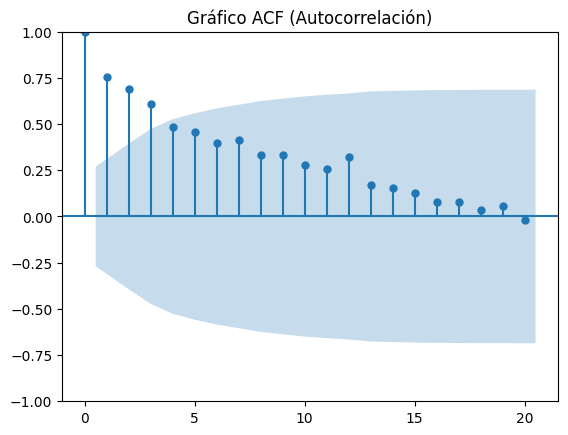

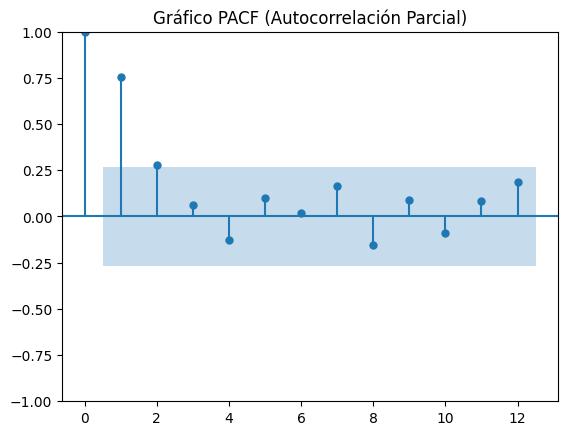

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráfico ACF

plot_acf(series, lags=20)
plt.title("Gráfico ACF (Autocorrelación)")
plt.show()

# Gráfico PACF

plot_pacf(series, lags=12)
plt.title("Gráfico PACF (Autocorrelación Parcial)")
plt.show()

## *2 Intepretación de los resultados*
📌 Interpretación de los resultados
- Si ADF dice que es estacionaria, pero KPSS dice que no, entonces la serie tiene tendencia y necesita diferenciación.
- Si Mann-Kendall detecta tendencia, confirma que la serie tiene un crecimiento o caída sostenida.
- Si ACF/PACF muestran picos en ciertos rezagos, esos rezagos se usan para definir p y q en ARIMA.

✅ Si solo hay tendencia → Se recomienda Holt (suavizamiento doble) o ARIMA con diferenciación.

✅ Si hay tendencia + estacionalidad → Se recomienda Holt-Winters (suavizamiento triple) o SARIMA.


In [12]:
print('**** Resumen de Resultados ****')
print('\n')
print("\nPrueba Dickey-Fuller Aumentada (ADF):")
print(f"Estadístico de prueba: {adf_test[0]}")
print(f"p-valor: {adf_test[1]}")
print(f"Valores críticos: {adf_test[4]}")

if adf_test[1] < 0.05:
    print("✅ La serie es estacionaria.")
else:
    print("❌ La serie tiene tendencia (no es estacionaria).")
print('\n')
print("\nPrueba KPSS:")
print(f"Estadístico de prueba: {kpss_test[0]}")
print(f"p-valor: {kpss_test[1]}")
print(f"Valores críticos: {kpss_test[3]}")

if kpss_test[1] < 0.05:
    print("❌ La serie tiene tendencia (no es estacionaria).")
else:
    print("✅ La serie es estacionaria.")
print('\n')

print("\nPrueba Mann-Kendall:")
print(f"p-valor: {mk_result.p}")
print(f"Tendencia detectada: {mk_result.trend}")

if mk_result.trend == "no trend":
    print("✅ No hay tendencia significativa.")
elif mk_result.trend == "increasing":
    print("📈 Se detecta una tendencia creciente.")
elif mk_result.trend == "decreasing":
    print("📉 Se detecta una tendencia decreciente.")

**** Resumen de Resultados ****



Prueba Dickey-Fuller Aumentada (ADF):
Estadístico de prueba: 1.1634151775453687
p-valor: 0.9957231084311645
Valores críticos: {'1%': np.float64(-3.60098336718852), '5%': np.float64(-2.9351348158036012), '10%': np.float64(-2.6059629803688282)}
❌ La serie tiene tendencia (no es estacionaria).



Prueba KPSS:
Estadístico de prueba: 1.000258462326453
p-valor: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
❌ La serie tiene tendencia (no es estacionaria).



Prueba Mann-Kendall:
p-valor: 6.636247107394411e-12
Tendencia detectada: decreasing
📉 Se detecta una tendencia decreciente.


In [13]:
def ask_stat_tests():
    print("Introduce los resultados de las pruebas estadísticas:")

    # Prueba Dickey-Fuller ADF
    adf_p_value = float(input("📌 Prueba ADF - p-valor (Ejemplo: 0.03): "))
    adf_stationary = adf_p_value < 0.05

    # Prueba KPSS
    kpss_p_value = float(input("📌 Prueba KPSS - p-valor (Ejemplo: 0.07): "))
    kpss_stationary = kpss_p_value > 0.05

    # Test Mann-Kendall
    mk_trend = input("📌 Prueba Mann-Kendall - Tendencia ('no trend', 'increasing' o 'decreasing'): ").lower()

    # ACF/PACF
    acf_cutoff = int(input("📌 Gráfico ACF - ¿En qué rezago se corta la autocorrelación? (Ejemplo: 1, 2, etc.): "))
    pacf_cutoff = int(input("📌 Gráfico PACF - ¿En qué rezago se corta la autocorrelación? (Ejemplo: 1, 2, etc.): "))

    return adf_stationary, kpss_stationary, mk_trend, acf_cutoff, pacf_cutoff


def recommend_model(adf_stationary, kpss_stationary, mk_trend, acf_cutoff, pacf_cutoff):
    print("\n🔍 Análisis de resultados:")

    # Determinar si hay tendencia o estacionalidad
    has_trend = mk_trend in ["increasing", "decreasing"]
    has_seasonality = acf_cutoff >= 2 or pacf_cutoff >= 2

    # Recomendaciones de modelos
    if adf_stationary and kpss_stationary and mk_trend == "no trend":
        print("✅ La serie es estacionaria sin tendencia ni estacionalidad.")
        print("🔹 Recomiendo: **Suavizamiento Exponencial Simple** o **ARMA (ARIMA sin diferenciación)**.")
    elif has_trend and not has_seasonality:
        print("✅ La serie tiene tendencia, pero no estacionalidad.")
        print("🔹 Recomiendo: **Suavizamiento Exponencial Doble (Holt)** o **ARIMA con d=1**.")
    elif has_seasonality and not has_trend:
        print("✅ La serie tiene estacionalidad, pero no tendencia.")
        print("🔹 Recomiendo: **Suavizamiento Exponencial Triple (Holt-Winters)** o **SARIMA**.")
    elif has_trend and has_seasonality:
        print("✅ La serie tiene tendencia y estacionalidad.")
        print("🔹 Recomiendo: **SARIMA** o **Holt-Winters con optimización**.")
    else:
        print("⚠️ No se pudo determinar claramente un patrón. Puedes revisar los datos o probar modelos híbridos.")

# Ejecutar el código
adf_stationary, kpss_stationary, mk_trend, acf_cutoff, pacf_cutoff = ask_stat_tests()
recommend_model(adf_stationary, kpss_stationary, mk_trend, acf_cutoff, pacf_cutoff)

Introduce los resultados de las pruebas estadísticas:

🔍 Análisis de resultados:
✅ La serie tiene tendencia y estacionalidad.
🔹 Recomiendo: **SARIMA** o **Holt-Winters con optimización**.


## *3 Modelos de predicción*

### *3.1 Exponential Smoothing & ARIMA*

In [14]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Crear df_working
df_working = df_baking.copy()


# Identifica la fecha más reciente del dataset
max_date = df_working['date'].max()
print("Fecha más reciente:", max_date)

# Crear la serie de datos
series_fore = df_baking[['date', 'calls']]

# Ajustar el modelo de suavizamiento exponencial
model = SimpleExpSmoothing(series_fore['calls']).fit(optimized=True)

# Generar pronóstico pasado: desde 3 periodos antes de la fecha más reciente
past_periods = 3
past_dates = pd.date_range(start=max_date - pd.DateOffset(months=past_periods), periods=past_periods, freq='M')
pastfore = pd.DataFrame({'date': past_dates, 'calls': model.predict(start=len(series_fore)-past_periods, end=len(series_fore)-1)})

# Generar pronóstico futuro: desde el periodo posterior a la fecha más reciente hasta 4 meses después
future_periods = 4
future_dates = pd.date_range(start=max_date, periods=future_periods, freq='M')
futurefore = pd.DataFrame({'date': future_dates, 'calls': model.forecast(future_periods)})

# Consolidar pronósticos en un DataFrame sin modificar el índice
cons_fore = pd.concat([pastfore, futurefore], ignore_index=True)

# Asegurar que las fechas tengan formato YYYY-MM-DD con día fijo 01
cons_fore['date'] = pd.to_datetime(cons_fore['date']).dt.strftime('%Y-%m-01')

# Crear el nuevo dataframe act_vs_fore
act_vs_fore = cons_fore.copy()

# Agregar la columna 'actuals' con valores de df_working['calls'] cuando las fechas coincidan
act_vs_fore['actuals'] = act_vs_fore['date'].map(lambda d: df_working.loc[df_working['date'] == d, 'calls'].values[0] if d in df_working['date'].astype(str).values else 0)

# Cambia el nombre a la columna act_vs_fore['calls'] por es_fore
act_vs_fore.rename(columns={'calls': 'es_fore'}, inplace=True)

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Crear df_arima como copia de df_baking
df_arima = df_baking.copy()

# Asegurar que 'date' esté en formato datetime
df_arima['date'] = pd.to_datetime(df_arima['date'])

# Crear la serie de datos para ARIMA
series_arima = df_arima[['date', 'calls']]

# Ajustar el modelo ARIMA sin diferenciación (d=0)
arima_model = ARIMA(series_arima['calls'], order=(2, 0, 2)).fit()

# Identificar la fecha más reciente en el dataset
max_date = df_arima['date'].max()

# Generar pronóstico pasado: desde 3 periodos antes de la fecha más reciente
past_periods = 3
past_dates = pd.date_range(start=max_date - pd.DateOffset(months=past_periods), periods=past_periods, freq='M')
past_forecast = arima_model.predict(start=len(series_arima)-past_periods-1, end=len(series_arima)-2)

# Generar pronóstico futuro: desde el periodo posterior a la fecha más reciente hasta 4 meses después
future_periods = 4
future_dates = pd.date_range(start=max_date, periods=future_periods, freq='M')
future_forecast = arima_model.forecast(steps=future_periods)

# Crear DataFrames con los pronósticos pasados y futuros
df_arima_past = pd.DataFrame({'date': past_dates, 'arima_calls': past_forecast.values})
df_arima_future = pd.DataFrame({'date': future_dates, 'arima_calls': future_forecast.values})

# Unir ambos pronósticos en un solo dataframe
df_arima_forecast = pd.concat([df_arima_past, df_arima_future], ignore_index=True)

# Asegurar que todas las fechas tengan el día 01 del mes
df_arima_forecast['date'] = df_arima_forecast['date'].dt.strftime('%Y-%m-01')
df_arima_forecast['date'] = pd.to_datetime(df_arima_forecast['date'])


# Crear el nuevo dataframe comparison como copia de cons_fore
comparison = act_vs_fore.copy()

# Agregar una columna al dataframe comparison llamada ['arima']
comparison['arima'] = df_arima_forecast['arima_calls']

# Cambia el orden del dataframe pon date actuals es_fore arima
comparison = comparison[['date', 'actuals', 'es_fore', 'arima']]

# Mostrar el resultado final
print("ES Forecast:")
print(act_vs_fore)
print("\nARIMA Forecast:")
print(comparison)

# Calcula las estadísticas de desempeño del pronóstico
mse = ((act_vs_fore['actuals'] - act_vs_fore['es_fore']) ** 2).mean()
mae = (abs(act_vs_fore['actuals'] - act_vs_fore['es_fore'])).mean


# Calcular las estadísticas de desempeño del pronóstico arima
mse = ((comparison['actuals'] - comparison['arima']) ** 2).mean()
mae = (abs(comparison['actuals'] - comparison['arima'])).mean
print('\n')
print("MSE_ES:", mse)
print("MSE_ARIMA:", mse)
print('\n')
print("MAE:_ES", mae)
print("MAE_ARIMA:", mae)




Fecha más reciente: 2025-01-05 00:00:00
ES Forecast:
         date       es_fore  actuals
0  2024-10-01  81869.439430        0
1  2024-11-01  83655.924773        0
2  2024-12-01  82610.944997        0
3  2025-01-01  82182.326387    81019
4  2025-02-01  82182.326387        0
5  2025-03-01  82182.326387        0
6  2025-04-01  82182.326387        0

ARIMA Forecast:
         date  actuals       es_fore         arima
0  2024-10-01        0  81869.439430  84785.288060
1  2024-11-01        0  83655.924773  88237.196555
2  2024-12-01        0  82610.944997  83207.537917
3  2025-01-01    81019  82182.326387  82057.941261
4  2025-02-01        0  82182.326387  87326.958637
5  2025-03-01        0  82182.326387  85042.706284
6  2025-04-01        0  82182.326387  89078.932756


MSE_ES: 6384605364.339906
MSE_ARIMA: 6384605364.339906


MAE:_ES <bound method Series.mean of 0    84785.288060
1    88237.196555
2    83207.537917
3     1038.941261
4    87326.958637
5    85042.706284
6    89078.932756
dtyp

### *3.2 Holt & ARIMA d=1*

In [26]:
import pandas as pd
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA

# =============================================================================
# Modelos con Suavizamiento Doble (Holt) – _DES
# =============================================================================

# Crear df_des como copia de df_baking (para el modelo de doble suavizamiento)
df_des = df_baking.copy()

# Identificar la fecha más reciente del dataset
max_date = df_des['date'].max()
print("Fecha más reciente:", max_date)

# Crear la serie de datos
series_fore = df_des[['date', 'calls']]

# Ajustar el modelo de suavizamiento doble (Holt)
holt_model = Holt(series_fore['calls']).fit(optimized=True)

# --- Pronóstico pasado DES:
# Generar pronóstico pasado: desde 3 periodos antes de la fecha más reciente
past_periods = 3
past_dates = pd.date_range(start=max_date - pd.DateOffset(months=past_periods),
                           periods=past_periods, freq='M')
# Predecimos usando índices: de len(series_fore)-past_periods hasta len(series_fore)-1
past_forecast_DES = holt_model.predict(start=len(series_fore) - past_periods,
                                        end=len(series_fore) - 1)
df_des_past = pd.DataFrame({'date': past_dates, 'calls': past_forecast_DES.values})

# --- Pronóstico futuro DES:
# Generar pronóstico futuro: desde la fecha más reciente hasta 4 meses después
future_periods = 4
future_dates = pd.date_range(start=max_date, periods=future_periods, freq='M')
future_forecast_DES = holt_model.forecast(future_periods)
df_des_future = pd.DataFrame({'date': future_dates, 'calls': future_forecast_DES.values})

# Consolidar pronósticos en un DataFrame sin modificar el índice
cons_fore_DES = pd.concat([df_des_past, df_des_future], ignore_index=True)



# Crear el dataframe de trabajo para comparar pronósticos DES con datos reales
act_vs_fore_DES = cons_fore_DES.copy()
# Al mapear la columna 'actuals' se convierte la fecha en el mismo formato (YYYY-MM-01)
act_vs_fore_DES['actuals'] = act_vs_fore_DES['date'].map(
    lambda d: df_des.loc[df_des['date'] == d, 'calls'].values[0]
              if d in df_des['date'].dt.strftime('%Y-%m-01').values else 0
)
# Renombrar la columna con los resultados del pronóstico DES
act_vs_fore_DES.rename(columns={'calls': 'des_fore'}, inplace=True)

# =============================================================================
# Modelo ARIMA con d=1 – ARIMAD1
# =============================================================================

# Crear df_arimad1 como copia de df_baking
df_arimad1 = df_baking.copy()
df_arimad1['date'] = pd.to_datetime(df_arimad1['date'])

# Crear la serie de datos para ARIMA con diferenciación d=1
series_arimad1 = df_arimad1[['date', 'calls']]

# Ajustar el modelo ARIMA con diferenciación de primer orden, por ejemplo order=(2,1,2)
arima_model_d1 = ARIMA(series_arimad1['calls'], order=(2, 1, 2)).fit()

# Identificar la fecha más reciente en df_arimad1
max_date_arima = df_arimad1['date'].max()

# --- Pronóstico pasado ARIMAD1:
past_dates_arima = pd.date_range(start=max_date_arima - pd.DateOffset(months=past_periods),
                                 periods=past_periods, freq='M')
# Para ARIMA usamos predict() sobre los últimos 'past_periods' registros
past_forecast_ARIMAD1 = arima_model_d1.predict(start=len(series_arimad1) - past_periods,
                                               end=len(series_arimad1) - 1)
df_arimad1_past = pd.DataFrame({'date': past_dates_arima, 'arimad1_calls': past_forecast_ARIMAD1.values})

# --- Pronóstico futuro ARIMAD1:
future_dates_arima = pd.date_range(start=max_date_arima, periods=future_periods, freq='M')
future_forecast_ARIMAD1 = arima_model_d1.forecast(steps=future_periods)
df_arimad1_future = pd.DataFrame({'date': future_dates_arima, 'arimad1_calls': future_forecast_ARIMAD1.values})

# Unir ambos pronósticos en un solo dataframe de ARIMA con d=1
df_arimad1_forecast = pd.concat([df_arimad1_past, df_arimad1_future], ignore_index=True)
df_arimad1_forecast['date'] = pd.to_datetime(df_arimad1_forecast['date']).dt.strftime('%Y-%m-01')
df_arimad1_forecast['date'] = pd.to_datetime(df_arimad1_forecast['date'])

# =============================================================================
# Comparación de Pronósticos (DES vs ARIMAD1)
# =============================================================================

# Crear el dataframe comparison como copia de act_vs_fore_DES
comparison = act_vs_fore_DES.copy()

# Agregar una nueva columna 'ARIMAD1' asignándole los resultados del pronóstico ARIMA en las fechas correspondientes
comparison['ARIMAD1'] = df_arimad1_forecast['arimad1_calls']

# Reordenar las columnas: date, actuals, des_fore, ARIMAD1
comparison = comparison[['date', 'actuals', 'des_fore', 'ARIMAD1']]

# Mostrar resultados finales
print("DES Forecast (Double Exponential Smoothing):")
print(act_vs_fore_DES)
print("\nARIMA with d=1 Forecast (ARIMAD1):")
print(comparison)

# =============================================================================
# Cálculo de Estadísticas de Desempeño
# =============================================================================

# Para el pronóstico DES
mse_DES = ((act_vs_fore_DES['actuals'] - act_vs_fore_DES['des_fore']) ** 2).mean()
mae_DES = (abs(act_vs_fore_DES['actuals'] - act_vs_fore_DES['des_fore'])).mean()

# Para el pronóstico ARIMAD1
mse_ARIMAD1 = ((comparison['actuals'] - comparison['ARIMAD1']) ** 2).mean()
mae_ARIMAD1 = (abs(comparison['actuals'] - comparison['ARIMAD1'])).mean()

print('\n')
print("MSE_DES:", mse_DES)
print("MAE_DES:", mae_DES)
print("MSE_ARIMAD1:", mse_ARIMAD1)
print("MAE_ARIMAD1:", mae_ARIMAD1)

Fecha más reciente: 2025-01-05 00:00:00


/workspaces/forecast_work_prework/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


DES Forecast (Double Exponential Smoothing):
        date      des_fore  actuals
0 2024-10-31  77608.202529        0
1 2024-11-30  80947.375190        0
2 2024-12-31  79937.869813        0
3 2025-01-31  79735.867597        0
4 2025-02-28  78400.017088        0
5 2025-03-31  77064.166578        0
6 2025-04-30  75728.316068        0

ARIMA with d=1 Forecast (ARIMAD1):
        date  actuals      des_fore       ARIMAD1
0 2024-10-31        0  77608.202529  75314.947210
1 2024-11-30        0  80947.375190  83181.667855
2 2024-12-31        0  79937.869813  86769.365151
3 2025-01-31        0  79735.867597  75131.265723
4 2025-02-28        0  78400.017088  81563.505933
5 2025-03-31        0  77064.166578  76879.596267
6 2025-04-30        0  75728.316068  78752.952385


MSE_DES: 6163372652.28451
MAE_DES: 78488.83069482163
MSE_ARIMAD1: 6361466612.826765
MAE_ARIMAD1: 79656.18578908111


/workspaces/forecast_work_prework/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### *3.3 Holt-Winters & SARIMA*

In [16]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# =============================================================================
# PARTE 1: Suavizamiento Exponencial TRIPLE (Holt-Winters) CON OPTIMIZACIÓN
# =============================================================================

# Crear df_hw como copia de df_baking para el modelo Holt-Winters
df_hw = df_baking.copy()
df_hw['date'] = pd.to_datetime(df_hw['date'])

# Identificar la fecha más reciente en df_hw
max_date_hw = df_hw['date'].max()
print("Fecha más reciente (Holt-Winters):", max_date_hw)

# Crear la serie de datos para HW
series_hw = df_hw[['date', 'calls']]

# Ajustar el modelo de Holt-Winters (triple exponencial) con optimización
hw_model = ExponentialSmoothing(series_hw['calls'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=12).fit(optimized=True)

# --- Pronóstico pasado (3 períodos) para Holt-Winters
past_periods = 3
past_dates_hw = pd.date_range(start=max_date_hw - pd.DateOffset(months=past_periods),
                              periods=past_periods, freq='M')
past_forecast_HW = hw_model.predict(start=len(series_hw) - past_periods,
                                    end=len(series_hw) - 1)
df_hw_past = pd.DataFrame({'date': past_dates_hw, 'calls': past_forecast_HW.values})

# --- Pronóstico futuro (4 períodos) para Holt-Winters
future_periods = 4
future_dates_hw = pd.date_range(start=max_date_hw, periods=future_periods, freq='M')
future_forecast_HW = hw_model.forecast(future_periods)
df_hw_future = pd.DataFrame({'date': future_dates_hw, 'calls': future_forecast_HW.values})

# Consolidar pronósticos en un DataFrame
cons_fore_HW = pd.concat([df_hw_past, df_hw_future], ignore_index=True)

# Asegurar que las fechas tengan siempre el día 01 del mes
cons_fore_HW['date'] = pd.to_datetime(cons_fore_HW['date']).dt.strftime('%Y-%m-01')
cons_fore_HW['date'] = pd.to_datetime(cons_fore_HW['date'])

# Crear el dataframe act_vs_fore_HW para comparación (datos reales vs HW)
act_vs_fore_HW = cons_fore_HW.copy()
act_vs_fore_HW['actuals'] = act_vs_fore_HW['date'].map(
    lambda d: df_hw.loc[df_hw['date'].dt.strftime('%Y-%m-01') == d.strftime('%Y-%m-01'), 'calls'].values[0]
    if (df_hw['date'].dt.strftime('%Y-%m-01') == d.strftime('%Y-%m-01')).any() else 0
)
# Renombrar la columna de pronóstico a 'hw_fore'
act_vs_fore_HW.rename(columns={'calls': 'hw_fore'}, inplace=True)

# =============================================================================
# PARTE 2: Modelo SARIMA CON OPTIMIZACIÓN
# =============================================================================

# Crear df_sarima como copia de df_baking para el modelo SARIMA
df_sarima = df_baking.copy()
df_sarima['date'] = pd.to_datetime(df_sarima['date'])

# Identificar la fecha más reciente en df_sarima
max_date_sarima = df_sarima['date'].max()

# Crear la serie de datos para SARIMA
series_sarima = df_sarima[['date', 'calls']]

# Ajustar el modelo SARIMA: (2,1,2) con estacionalidad (1,1,1,12)
sarima_model = SARIMAX(series_sarima['calls'],
                       order=(2, 1, 2),
                       seasonal_order=(1, 1, 1, 12)).fit(disp=False)

# --- Pronóstico pasado (3 períodos) para SARIMA
past_dates_sarima = pd.date_range(start=max_date_sarima - pd.DateOffset(months=past_periods),
                                  periods=past_periods, freq='M')
past_forecast_SARIMA = sarima_model.predict(start=len(series_sarima) - past_periods,
                                            end=len(series_sarima) - 1)
df_sarima_past = pd.DataFrame({'date': past_dates_sarima, 'sarima_calls': past_forecast_SARIMA.values})

# --- Pronóstico futuro (4 períodos) para SARIMA
future_dates_sarima = pd.date_range(start=max_date_sarima, periods=future_periods, freq='M')
future_forecast_SARIMA = sarima_model.forecast(steps=future_periods)
df_sarima_future = pd.DataFrame({'date': future_dates_sarima, 'sarima_calls': future_forecast_SARIMA.values})

# Unir ambos pronósticos en un DataFrame para SARIMA
df_sarima_forecast = pd.concat([df_sarima_past, df_sarima_future], ignore_index=True)
df_sarima_forecast['date'] = pd.to_datetime(df_sarima_forecast['date']).dt.strftime('%Y-%m-01')
df_sarima_forecast['date'] = pd.to_datetime(df_sarima_forecast['date'])

# =============================================================================
# PARTE 3: Construcción del DataFrame de Comparación
# =============================================================================

# Crear el DataFrame comparison como copia de act_vs_fore_HW
comparison = act_vs_fore_HW.copy()

# Agregar la columna 'SARIMA' con los resultados del pronóstico SARIMA para las fechas correspondientes
comparison['SARIMA'] = comparison['date'].map(
    lambda d: df_sarima_forecast.loc[df_sarima_forecast['date'] == d, 'sarima_calls'].values[0]
    if d in df_sarima_forecast['date'].values else 0
)

# Reordenar columnas: date, actuals, hw_fore, SARIMA
comparison = comparison[['date', 'actuals', 'hw_fore', 'SARIMA']]

# =============================================================================
# Mostrar resultados y calcular métricas de desempeño
# =============================================================================


print("\nSARIMA Forecast (with optimization):")
print(comparison)

# Métricas de desempeño:
mse_HW = ((act_vs_fore_HW['actuals'] - act_vs_fore_HW['hw_fore']) ** 2).mean()
mae_HW = (abs(act_vs_fore_HW['actuals'] - act_vs_fore_HW['hw_fore'])).mean()
mse_SARIMA = ((comparison['actuals'] - comparison['SARIMA']) ** 2).mean()
mae_SARIMA = (abs(comparison['actuals'] - comparison['SARIMA'])).mean()

print("\nPerformance Metrics:")
print("MSE_HW:", mse_HW)
print("MAE_HW:", mae_HW)
print("MSE_SARIMA:", mse_SARIMA)
print("MAE_SARIMA:", mae_SARIMA)

Fecha más reciente (Holt-Winters): 2025-01-05 00:00:00


/workspaces/forecast_work_prework/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



SARIMA Forecast (with optimization):
        date  actuals       hw_fore        SARIMA
0 2024-10-01        0  94812.497075  84712.195126
1 2024-11-01        0  76733.467161  83051.502373
2 2024-12-01        0  83236.867412  84180.774741
3 2025-01-01    81019  79570.863382  77310.583324
4 2025-02-01        0  77903.964148  74306.090159
5 2025-03-01        0  81966.343990  76151.120194
6 2025-04-01        0  79993.521406  66426.366500

Performance Metrics:
MSE_HW: 5856340060.661627
MAE_HW: 70870.68540159774
MSE_SARIMA: 5272387649.643827
MAE_SARIMA: 67505.2093955209


/workspaces/forecast_work_prework/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### *3.4 Prophet*

06:33:12 - cmdstanpy - INFO - Chain [1] start processing


06:33:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper
52 2025-01-05   87006.493360   77528.611525   96633.845852
53 2025-02-01  817588.459076  807570.886215  827603.134225
54 2025-03-01 -540740.581935 -550209.893496 -531086.015774
55 2025-04-01 -262333.138487 -271747.511169 -252680.871640
56 2025-05-01    4337.464976   -5468.323112   13799.317212


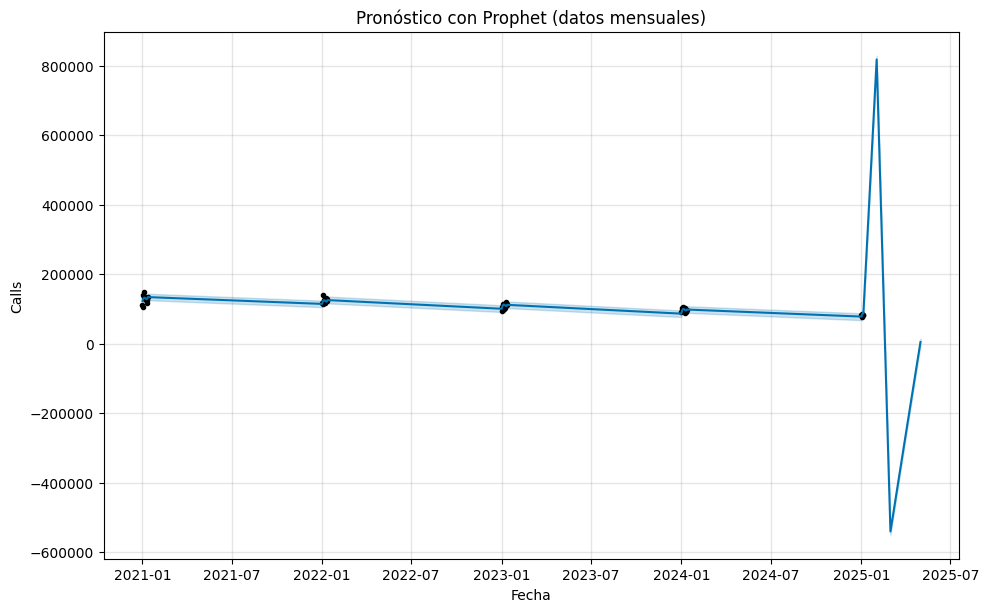

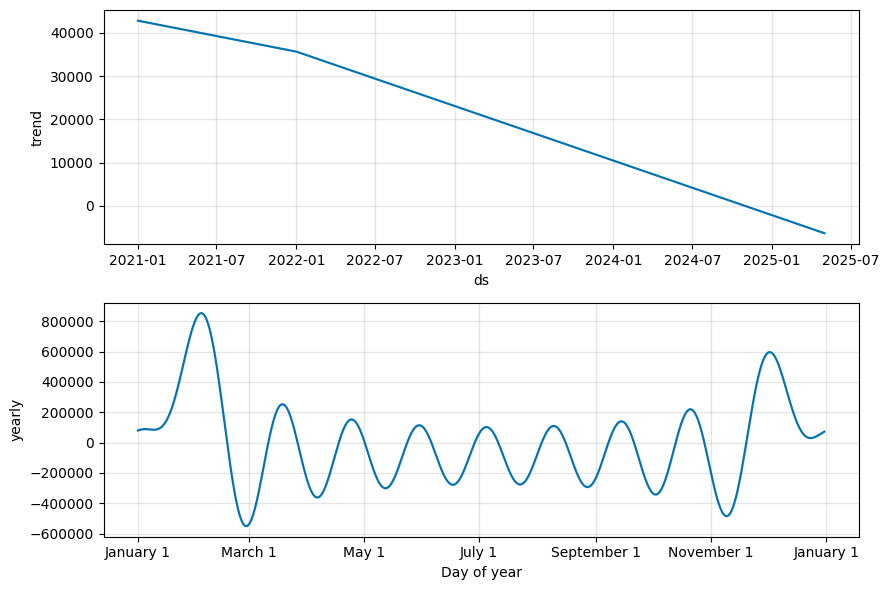

In [28]:
import pandas as pd
from prophet import Prophet  # Asegúrate de tener instalado 'prophet' (pip install prophet)
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Preparación de los datos para Prophet (datos mensuales)
# ---------------------------------------------------------------------------
df_prophet = df_baking.copy()
df_prophet['ds'] = df_prophet['date']
df_prophet['y'] = df_prophet['calls']
df_prophet = df_prophet[['ds', 'y']]
df_prophet = df_prophet.sort_values('ds')  # Asegurar que los datos estén ordenados

# ---------------------------------------------------------------------------
# Instanciación y ajuste del modelo Prophet
# ---------------------------------------------------------------------------
# Se ajusta para trabajar con datos mensuales:
# - growth: lineal
# - changepoint_prior_scale: 0.1 (un valor intermedio para dar algo de flexibilidad sin sobre-ajustar)
# - seasonality_mode: 'additive' (para que las fluctuaciones estacionales sean constantes en magnitud)
# - yearly_seasonality: activada (se espera un ciclo anual)
# - weekly_seasonality y daily_seasonality: desactivadas (ya que los datos son mensuales)
# - n_changepoints: reducido a 10 para evitar demasiados puntos de cambio en series con pocos datos
model = Prophet(
    growth='linear',
    changepoint_prior_scale=0.1,
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_changepoints=10
)

# Ajustar (fit) el modelo, la optimización interna se realiza durante el fit
model.fit(df_prophet)

# ---------------------------------------------------------------------------
# Creación del DataFrame futuro y pronóstico
# ---------------------------------------------------------------------------
# Como los datos son mensuales, usamos 'MS' (Month Start) para generar fechas con día 01.
# Se pronostican los próximos 4 meses.
future = model.make_future_dataframe(periods=4, freq='MS')
forecast = model.predict(future)

# Mostrar las últimas filas del pronóstico
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# ---------------------------------------------------------------------------
# Graficar el pronóstico y los componentes
# ---------------------------------------------------------------------------
fig1 = model.plot(forecast)
plt.title('Pronóstico con Prophet (datos mensuales)')
plt.xlabel('Fecha')
plt.ylabel('Calls')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
import pickle

# Crear diccionario de resultados
model_results = {
    'HoltWinters': {
        'forecast': act_vs_fore_HW,  # DataFrame con date, actuals y hw_fore
        'metrics': {
            'MSE': mse_HW,
            'MAE': mae_HW
        }
    },
    'SARIMA': {
        'forecast': comparison,  # DataFrame con date, actuals y SARIMA
        'metrics': {
            'MSE': mse_SARIMA,
            'MAE': mae_SARIMA
        },
        'model_summary': sarima_model.summary().as_text()  # Resumen del modelo SARIMA (opcional)
    },
    'Prophet': {
        'forecast': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],  # Pronóstico de Prophet
        'model_params': model.params  # Parámetros ajustados del modelo Prophet
    }
}

# Guardar el diccionario en un archivo 'model_results.pkl'
with open('model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

print("Diccionario de resultados guardado en 'model_results.pkl'")

Diccionario de resultados guardado en 'model_results.pkl'


In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle
from prophet import Prophet  # Asegúrate de tener instalado prophet (pip install prophet)
import matplotlib.pyplot as plt

st.title("Aplicación de Pronóstico de Datos Mensuales con Prophet")

# ========= Sección 1: Carga de Datos =========
st.header("Carga de Datos")
st.write("El archivo debe tener las siguientes columnas: **calls**, **aht** y **date**. " +
         "La fecha debe tener el formato **d/m/YYYY** (por ejemplo, 1/1/2023, 2/1/2023, etc.).")
uploaded_file = st.file_uploader("Cargar archivo CSV", type=["csv"])

if uploaded_file is not None:
    try:
        # Leer el archivo CSV
        df = pd.read_csv(uploaded_file)
        st.write("Datos cargados:")
        st.dataframe(df.head())

        # Verificar que existan las columnas requeridas
        required_cols = ['calls', 'aht', 'date']
        if not all(col in df.columns for col in required_cols):
            st.error("El archivo no contiene las columnas requeridas. " +
                     "Asegúrate de incluir 'calls', 'aht' y 'date'.")
        else:
            # Convertir la columna 'date' al formato datetime
            try:
                df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
            except Exception as e:
                st.error("Error al convertir la columna 'date': " + str(e))

            # ========= Sección 2: Estadísticas Descriptivas y Pruebas =========
            st.header("Estadísticas Descriptivas")
            st.write(df.describe())

            st.header("Ingrese Resultados de Pruebas Estadísticas")
            mse_input = st.number_input("Ingrese valor de MSE", min_value=0.0, value=0.0, step=0.1)
            mae_input = st.number_input("Ingrese valor de MAE", min_value=0.0, value=0.0, step=0.1)

            # ========= Sección 3: Pronóstico con Prophet =========
            st.header("Pronóstico con Prophet")
            forecast_horizon = st.number_input("Número de meses a pronosticar", min_value=1, value=4, step=1)

            # Preparación de los datos para Prophet:
            df_prophet = df[['date', 'calls']].rename(columns={'date': 'ds', 'calls': 'y'})
            df_prophet = df_prophet.sort_values("ds")

            # Instanciar el modelo Prophet:
            model = Prophet(
                growth='linear',
                changepoint_prior_scale=0.1,
                seasonality_mode='additive',
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                n_changepoints=10
            )
            with st.spinner("Entrenando el modelo Prophet..."):
                model.fit(df_prophet)

            # Crear dataframe futuro; usamos 'MS' para tener fechas con día 01 (Month Start)
            future = model.make_future_dataframe(periods=int(forecast_horizon), freq="MS")
            forecast = model.predict(future)

            st.subheader("Resultados del Pronóstico")
            st.write(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(int(forecast_horizon)))

            # Graficar el pronóstico
            st.subheader("Gráfica del Pronóstico")
            fig1 = model.plot(forecast)
            st.pyplot(fig1)

            # Graficar los componentes del pronóstico
            st.subheader("Componentes del Pronóstico")
            fig2 = model.plot_components(forecast)
            st.pyplot(fig2)

            # ========= Sección 4: Consolida Resultados y Guardado =========
            st.header("Guardar Resultados")
            results_dict = {
                'Prophet': {
                    'forecast': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                    'model_params': model.params,
                    'user_stats': {
                        'MSE': mse_input,
                        'MAE': mae_input
                    },
                    'data': df_prophet
                }
            }
            if st.button("Guardar resultados en model_results.pkl"):
                with open('model_results.pkl', 'wb') as f:
                    pickle.dump(results_dict, f)
                st.success("Resultados guardados en 'model_results.pkl'.")

    except Exception as e:
        st.error("Error al cargar o procesar el archivo: " + str(e))
else:
    st.info("Por favor, carga un archivo CSV para continuar.")

Writing app.py


ERROR:pyngrok.process.ngrok:t=2025-05-07T06:55:34+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-07T06:55:34+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-07T06:55:34+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.